In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_folder = '/content/drive/MyDrive/data/cats_and_dogs_small.zip'

In [3]:
import os, shutil, zipfile
local_zip = '/content/drive/MyDrive/data/cats_and_dogs_small.zip'
zip_ref = zipfile.ZipFile(data_folder, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
original_db_dir = './train'
base_dir = '/content/cats_and_dogs_small'

In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import models
from tensorflow.keras import optimizers

In [10]:
from keras.models import load_model
model_loc = '/content/drive/MyDrive/data/models/cats_and_dogs_small_2.h5'
model = load_model('/content/drive/MyDrive/data/models/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [11]:
img_path = './cats_and_dogs_small/test/cats/cat.1700.jpg'
from keras.preprocessing import image 
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


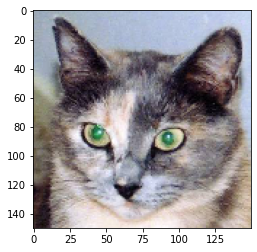

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [13]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
#입력 이미지가 주어지면 이 모델은 원본 모델의 활성화 값을 반환 → 이 모델은 1개의 입력과 층의 활성화마다 하나씩 총 8개의 출력을 가짐
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print (first_layer_activation.shape)

(1, 148, 148, 32)


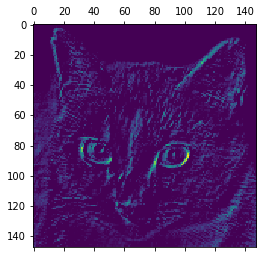

In [14]:
#원본 모델의 첫번째 층 활성화 중에서 20번째 채널을 시각화
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

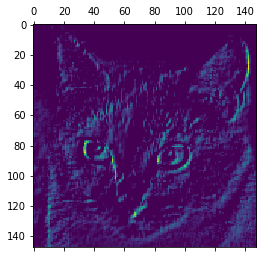

In [15]:
# 원본 모델의 첫번째 층 활성화 중에서 16번째 채널을 시각화
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

In [16]:
# 중간층의 모든 활성화 채널 시각화
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)
layer_names

['conv2d_8',
 'max_pooling2d_8',
 'conv2d_9',
 'max_pooling2d_9',
 'conv2d_10',
 'max_pooling2d_10',
 'conv2d_11',
 'max_pooling2d_11']

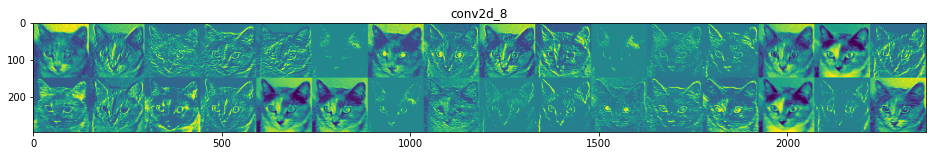

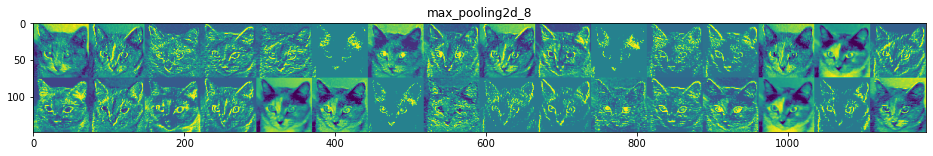

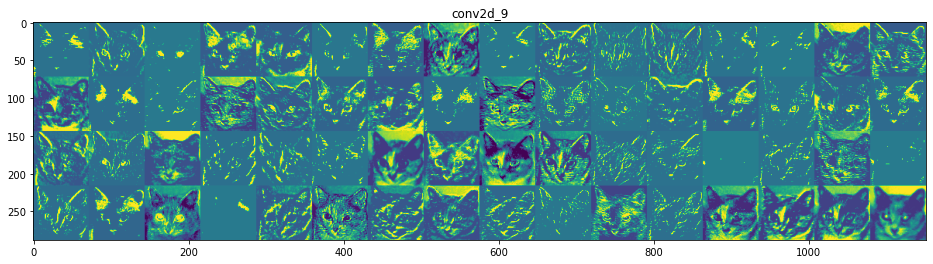

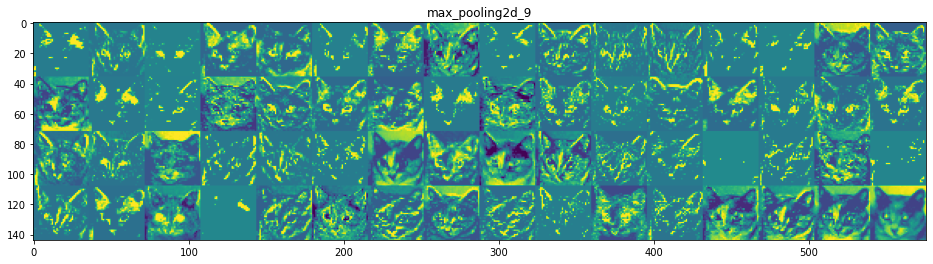

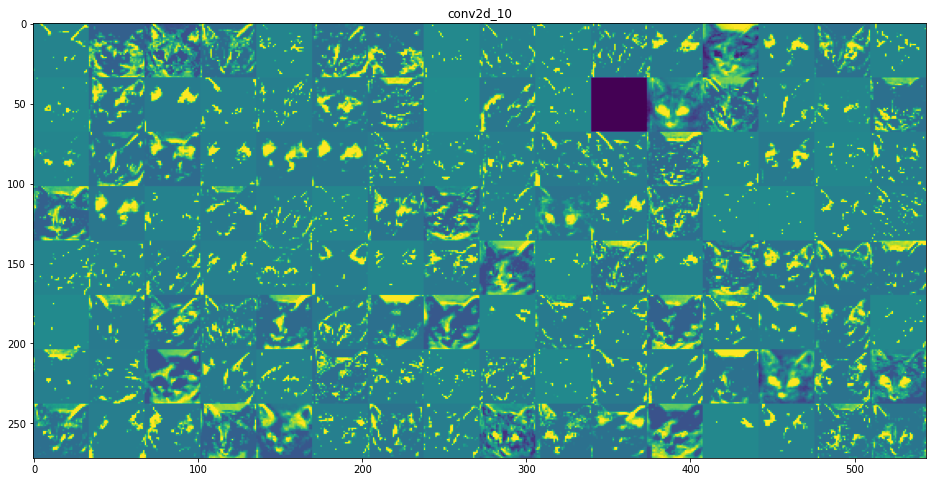

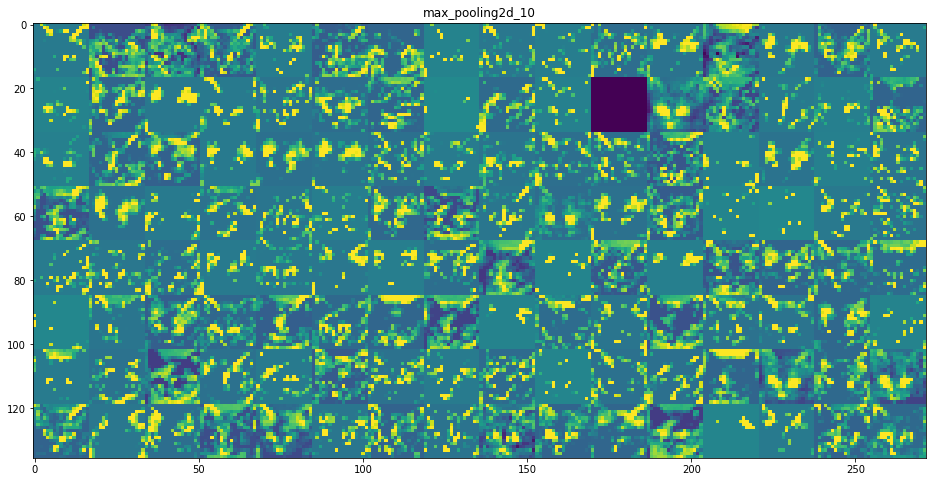

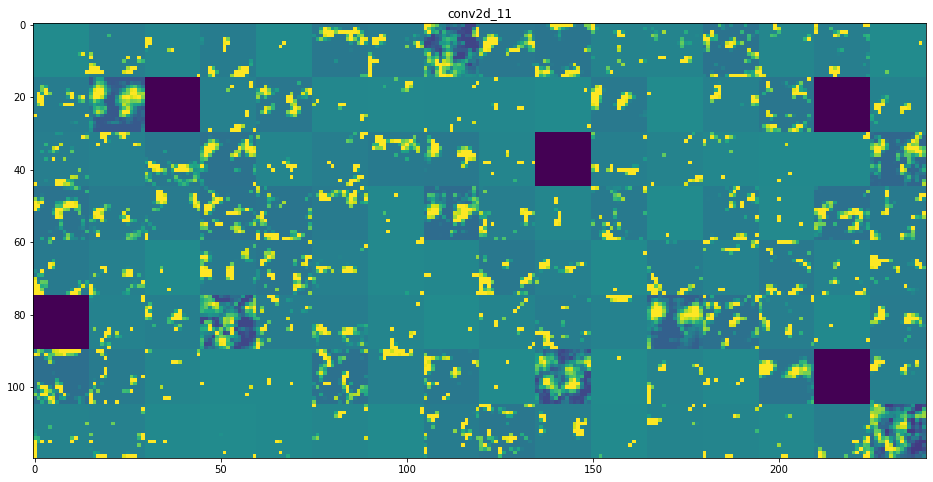

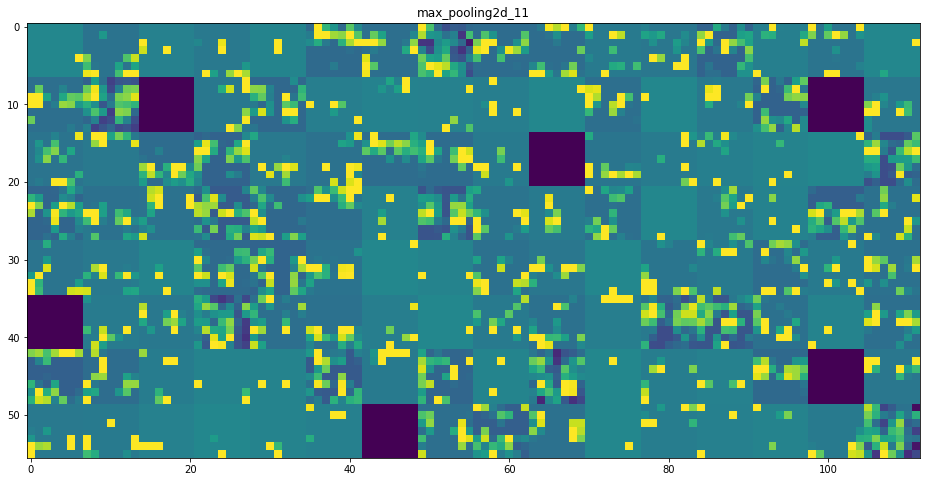

In [18]:
# 중간층의 모든 활성화 채널 시각화
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras import backend as K

tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet', include_top=False)
x = [l for l in model.layers]
layer_name = x[1].name
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [35]:
# 경사상승법을 구현하기 위해 모델의 입력에 대한 손실의 그레디언트가 필요
grads = K.gradients(loss, model.input)[0]


In [36]:
# 그래디언트 정규화
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [37]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [38]:
# 확률적 경사상승법을 구성
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

In [39]:
# 텐서를 이미지 형태로 변환하는 유틸리티 함수
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [55]:
# 필터 시각화 이미지를 만드는 함수
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  img = input_img_data[0]
  return deprocess_image(img)

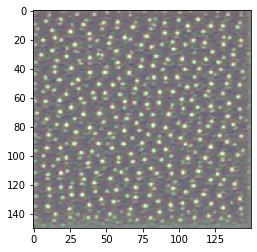

In [53]:
plt.imshow(generate_pattern('block3_conv1', 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


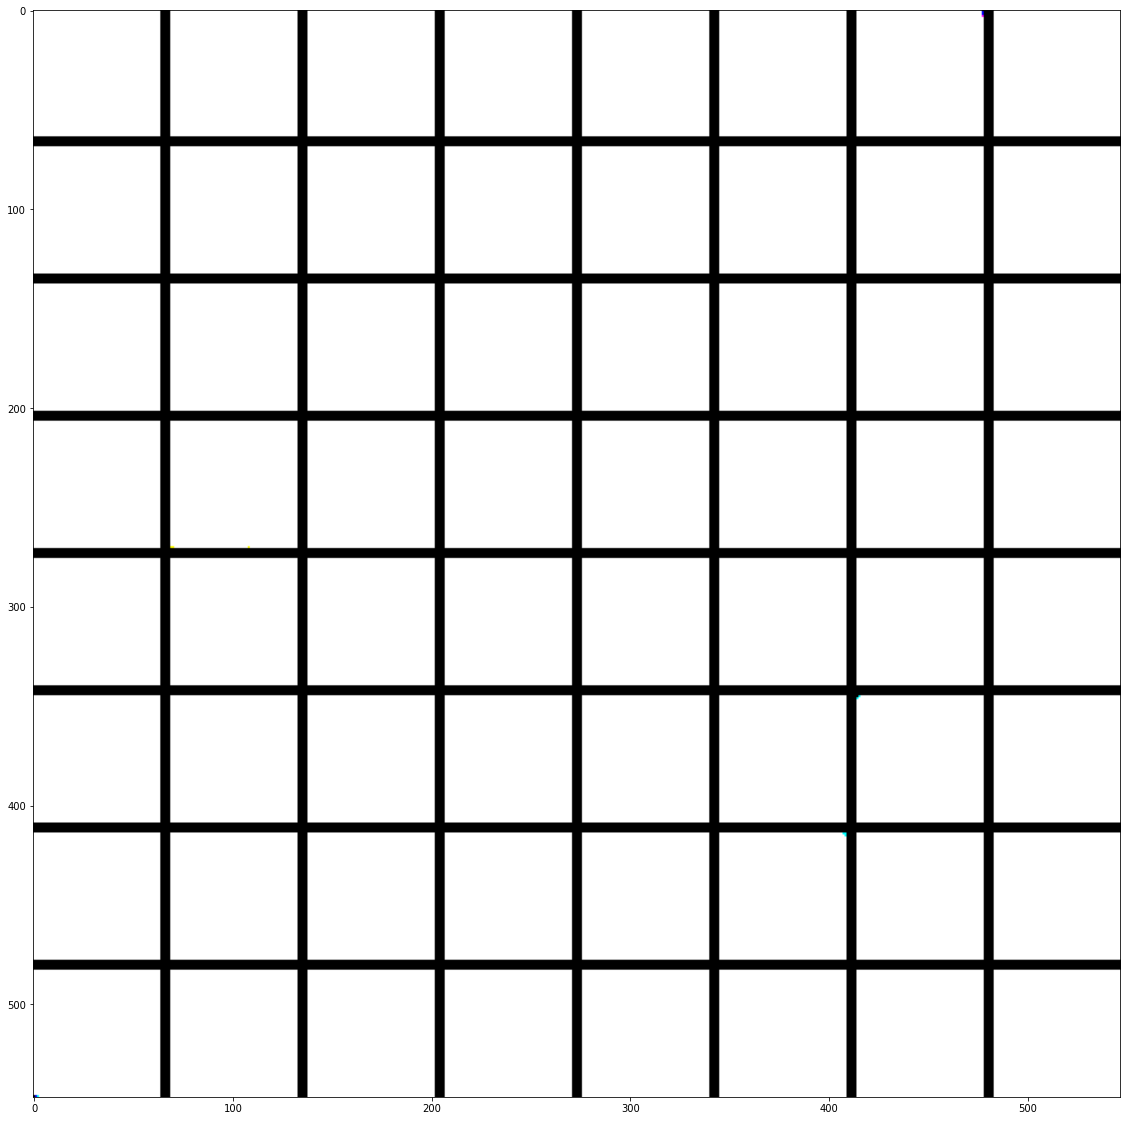

In [54]:
# 층에 있는 각 필터에 반응하는 패턴 생성
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)